# Database description

- **VENUE_ID**: Integer that uniquely defines a venue or studio
- **VENUE_STATUS**: Either an "active" (live) venue or identified as "churned" (no longer on the platform)
- **INTEGRATION_SOURCE**: Either manual (does not have a booking software connected to ClassPass) or integrated (has a booking software connected to ClassPass) as defined above
- **SMARTSPOT_ENABLED**: TRUE means the partner is opted into our automated spot management technology that uses historical data to set how many spots are available to book on ClassPass
- **ADDITIONAL_PHOTOS**: TRUE means has more than 1 photo, False means 0 or 1 photos attached to the partner's profile
- **REVIEWS**: TRUE means the partner has a customer review connected to their profile
- **REV_30_DAYS**: Revenue earned in the last 30 days
- **VENUE_LIFECYCLE**: How long the partner has been on ClassPass. "Early" is within 90 days of joining ClassPass and "Established" is after 90 days of joining ClassPass



In [12]:
import pandas as pd

# Read the CSV file into a DataFrame
raw_data = pd.read_csv("raw_data.csv", sep=";")

# Display the first few rows of the DataFrame to ensure it's read correctly
raw_data.head()

,VENUE_ID,VENUE_STATUS,INTEGRATION_SOURCE,SMARTSPOT_ENABLED,ADDITIONAL_PHOTOS,REVIEWS,REV_30_DAYS,VENUE_LIFECYCLE
0,1,ACTIVE,INTEGRATED,True,False,False,R$368,ESTABLISHED
1,2,ACTIVE,MANUAL,False,False,False,R$51,ESTABLISHED
2,3,ACTIVE,INTEGRATED,True,True,True,R$4.635,ESTABLISHED
3,4,ACTIVE,INTEGRATED,False,True,True,R$576,ESTABLISHED
4,5,ACTIVE,MANUAL,False,False,False,R$96,ESTABLISHED


In [13]:
clean_df = raw_data

# Clean the REV_30_DAYS column
clean_df['REV_30_DAYS'] = clean_df['REV_30_DAYS'].str.strip()
clean_df['REV_30_DAYS'] = clean_df['REV_30_DAYS'].str.replace('R\$', '', regex=True).str.replace('.', '', regex=False).astype(int)

# Transform the VENUE_LIFECYCLE column
# ESTABLISHED = 1
# EARLY = 0
clean_df['VENUE_LIFECYCLE'] = clean_df['VENUE_LIFECYCLE'].str.replace('ESTABLISHED','1',regex=False).str.replace('EARLY','0',regex=False).astype(int)

# Transform the INTEGRATION_SOURCE column
# INTEGRATED = 1
# MANUAL = 0
clean_df['INTEGRATION_SOURCE'] = clean_df['INTEGRATION_SOURCE'].str.replace('INTEGRATED','1',regex=False).str.replace('MANUAL','0',regex=False).astype(int)

# Transform the VENUE_STATUS column
# ACTIVE = 1
# CHURNED = 0
clean_df['VENUE_STATUS'] = clean_df['VENUE_STATUS'].str.replace('ACTIVE','1',regex=False).str.replace('CHURNED','0',regex=False).astype(int)

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   VENUE_ID            8190 non-null   int64
 1   VENUE_STATUS        8190 non-null   int64
 2   INTEGRATION_SOURCE  8190 non-null   int64
 3   SMARTSPOT_ENABLED   8190 non-null   bool 
 4   ADDITIONAL_PHOTOS   8190 non-null   bool 
 5   REVIEWS             8190 non-null   bool 
 6   REV_30_DAYS         8190 non-null   int64
 7   VENUE_LIFECYCLE     8190 non-null   int64
dtypes: bool(3), int64(5)
memory usage: 344.0 KB


In [15]:
# Use the agg function to count and sum
df = clean_df.groupby('VENUE_LIFECYCLE').agg({
    'VENUE_ID': 'count',
    'REV_30_DAYS': 'mean',
    'VENUE_STATUS': 'count',  # Assuming VENUE_STATUS count is relevant
    'ADDITIONAL_PHOTOS': 'sum',
    'INTEGRATION_SOURCE': 'sum',
    'SMARTSPOT_ENABLED': 'sum',
    'REVIEWS': 'sum',
    
}).reset_index()

# Calculate total VENUE_ID count for percentage calculation
total_venue_count = clean_df['VENUE_ID'].count()

# Calculate percentages
df['VENUE_ID_PERCENT'] = (df['VENUE_ID'] / total_venue_count) * 100

# Display the resulting DataFrame
print(df)



   VENUE_LIFECYCLE  VENUE_ID  REV_30_DAYS  VENUE_STATUS  ADDITIONAL_PHOTOS  \
0                0       679   703.924890           679                555   
1                1      7511  1231.632273          7511               5736   

   INTEGRATION_SOURCE  VENUE_ID_PERCENT  
0                 679          8.290598  
1                7511         91.709402  


In [26]:
# Aggregating counts and sums
df = clean_df.groupby('VENUE_LIFECYCLE').agg({
    'VENUE_ID': 'count',
    'REV_30_DAYS': 'mean',
    'INTEGRATION_SOURCE': 'sum',
    'ADDITIONAL_PHOTOS': 'sum',
    'SMARTSPOT_ENABLED': 'sum',
    'REVIEWS': 'sum',
    'VENUE_STATUS': lambda x: (x == 0).sum()  # Counting churned venues
}).reset_index()

# Renaming the columns for better clarity
df.rename(columns={'VENUE_STATUS': 'churn'}, inplace=True)

# Calculate total VENUE_ID count for percentage calculation
total_venue_count = clean_df['VENUE_ID'].count()

# Calculate the percentages for each relevant column
df['INTEGRATION_SOURCE rate %'] = (df['INTEGRATION_SOURCE'] / df['VENUE_ID']) * 100
df['ADDITIONAL_PHOTOS rate %'] = (df['ADDITIONAL_PHOTOS'] / df['VENUE_ID']) * 100
df['SMARTSPOT_ENABLED rate %'] = (df['SMARTSPOT_ENABLED'] / df['VENUE_ID']) * 100
df['REVIEWS rate %'] = (df['REVIEWS'] / df['VENUE_ID']) * 100

# Calculate the churn rate
df['churn rate %'] = (df['churn'] / df['VENUE_ID']) * 100

df = df.round(2)

# Display the resulting DataFrame
print(df[['VENUE_LIFECYCLE', 'VENUE_ID', 'REV_30_DAYS', 'INTEGRATION_SOURCE rate %', 'ADDITIONAL_PHOTOS rate %', 'SMARTSPOT_ENABLED rate %', 'REVIEWS rate %', 'churn', 'churn rate %']])


   VENUE_LIFECYCLE  VENUE_ID  REV_30_DAYS  INTEGRATION_SOURCE rate %  \
0                0       679       703.92                      41.68   
1                1      7511      1231.63                      50.11   

   ADDITIONAL_PHOTOS rate %  SMARTSPOT_ENABLED rate %  REVIEWS rate %  churn  \
0                     81.74                     36.67           73.64     29   
1                     76.37                     43.99           72.39    282   

   churn rate %  
0          4.27  
1          3.75  


1. Revenue Growth with Lifecycle:

Venues in the established lifecycle category tend to generate significantly higher average revenue compared to early lifecycle venues. This suggests that venues become more profitable as they spend more time on the platform.

2. Integration and SmartSpot Utilization:

Established venues have higher rates of integration with booking software and SmartSpot enabled. This may indicate that more mature venues are better at leveraging platform tools to optimize their operations and increase revenue.

3. Consistency in Reviews:

The percentage of venues with reviews is similar across both lifecycle categories, indicating that obtaining reviews is important for venues regardless of their stage in the lifecycle.

4. Churn Rates:

The slightly lower churn rate in the established category suggests that venues that stay on the platform longer are less likely to churn, possibly due to better engagement and utilization of platform features.

5. Additional Photos:

Interestingly, a higher percentage of early lifecycle venues have additional photos compared to established venues. This could imply that new venues are more proactive in updating their profiles with photos when they join, or that established venues may not update their photos as frequently.


<Axes: >

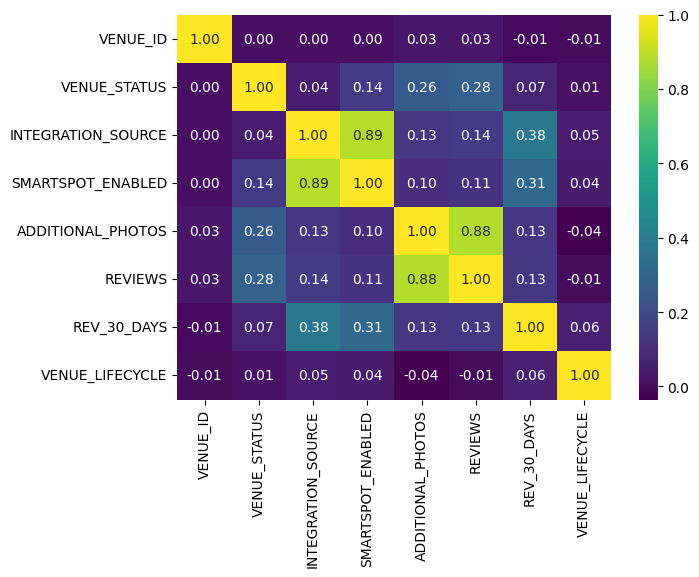

In [19]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.heatmap(correlation,annot=True,cmap='viridis',fmt=".2f")

1. Very Strong Correlations: Integration source with SMARTSPOT enabled, and additional photos with reviews.
2. Moderate Correlations: Integration source and SMARTSPOT enabled with revenue in the last 30 days.
3. Weak Correlations: Venue status with reviews and additional photos; integration source with additional photos.
4. Negligible Correlations: VENUE_ID with other variables; venue status with lifecycle.


In [21]:
status_mean_df = clean_df.groupby('VENUE_STATUS').mean(numeric_only=True).round(2).reset_index()
status_mean_df = status_mean_df.drop(columns=['VENUE_ID'])
status_mean_df


,VENUE_STATUS,INTEGRATION_SOURCE,SMARTSPOT_ENABLED,ADDITIONAL_PHOTOS,REVIEWS,REV_30_DAYS,VENUE_LIFECYCLE
0,0,0.38,0.10,0.23,0.09,403.34,0.91
1,1,0.50,0.45,0.79,0.75,1218.85,0.92


1. Higher Engagement and Technology Use: Venues with status 1 are more likely to be integrated with booking software, have SmartSpot enabled, additional photos, and reviews. This suggests higher engagement with the platform and utilization of available features.

2. Revenue Impact: The higher engagement and utilization of features (integration, SmartSpot, additional photos, and reviews) in venues with status 1 correlate with significantly higher revenue in the last 30 days. This suggests that these features may positively impact revenue.

3. Lifecycle Similarity: The similarity in the venue lifecycle stage between the two statuses indicates that the differences observed are likely not due to the age or maturity of the venues on the platform but rather their engagement and use of platform features.

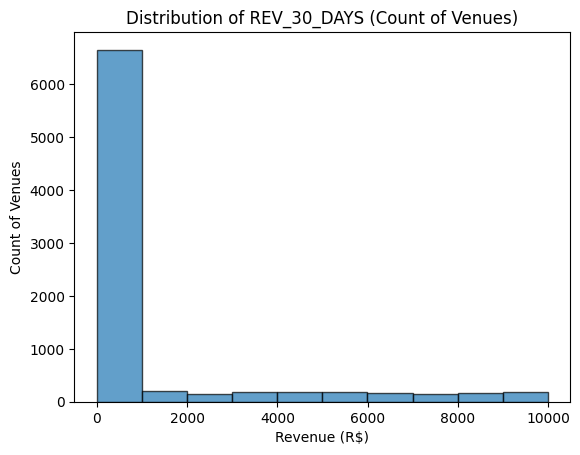

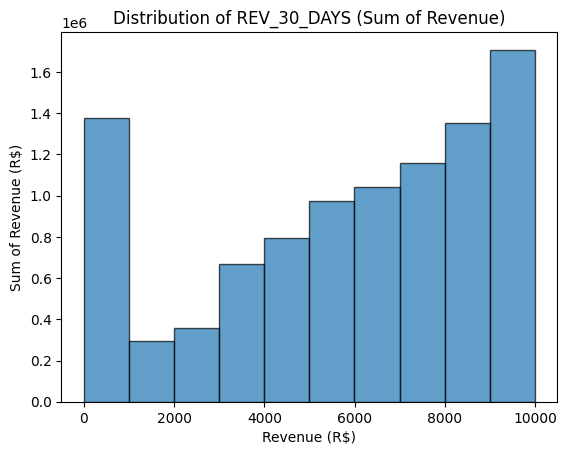

Bin range: 1.00 - 1000.50, Count: 6652, Percentage of total count: 81.22%, Bin Sum R$: 1375962.00, Percentage of total REV_30_DAYS: 14.14%
Bin range: 1000.50 - 2000.00, Count: 194, Percentage of total count: 2.37%, Bin Sum R$: 292948.00, Percentage of total REV_30_DAYS: 3.01%
Bin range: 2000.00 - 2999.50, Count: 145, Percentage of total count: 1.77%, Bin Sum R$: 355925.00, Percentage of total REV_30_DAYS: 3.66%
Bin range: 2999.50 - 3999.00, Count: 191, Percentage of total count: 2.33%, Bin Sum R$: 667920.00, Percentage of total REV_30_DAYS: 6.87%
Bin range: 3999.00 - 4998.50, Count: 177, Percentage of total count: 2.16%, Bin Sum R$: 796170.00, Percentage of total REV_30_DAYS: 8.18%
Bin range: 4998.50 - 5998.00, Count: 177, Percentage of total count: 2.16%, Bin Sum R$: 972170.00, Percentage of total REV_30_DAYS: 9.99%
Bin range: 5998.00 - 6997.50, Count: 160, Percentage of total count: 1.95%, Bin Sum R$: 1039988.00, Percentage of total REV_30_DAYS: 10.69%
Bin range: 6997.50 - 7997.00, C

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(data, bins, xlabel, ylabel, title):
    fig, ax = plt.subplots()
    ax.hist(data, bins=bins, edgecolor='black', alpha=0.7)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

def plot_bar(data, bins, xlabel, ylabel, title):
    fig, ax = plt.subplots()
    ax.bar(bins[:-1], data, width=np.diff(bins), edgecolor='black', align='edge', alpha=0.7)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

bin_count = 10

# Plot the histogram with count of venues
plot_histogram(clean_df['REV_30_DAYS'], bin_count, 'Revenue (R$)', 'Count of Venues', 'Distribution of REV_30_DAYS (Count of Venues)')

# Calculate the histogram values and bin edges
hist, bin_edges = np.histogram(clean_df['REV_30_DAYS'], bins=bin_count)

# Calculate the total count and total sum of REV_30_DAYS
total_count = len(clean_df['REV_30_DAYS'])
total_sum = clean_df['REV_30_DAYS'].sum()

# Calculate the sum of values in each bin
bin_sums = np.zeros(len(hist))
for i in range(len(hist)):
    bin_sums[i] = clean_df[(clean_df['REV_30_DAYS'] >= bin_edges[i]) & (clean_df['REV_30_DAYS'] < bin_edges[i+1])]['REV_30_DAYS'].sum()

# Calculate the percentage each bin represents of the total count and total sum
count_percentages = (hist / total_count) * 100
sum_percentages = (bin_sums / total_sum) * 100


# Plot the histogram with sum of revenues
plot_bar(bin_sums, bin_edges, 'Revenue (R$)', 'Sum of Revenue (R$)', 'Distribution of REV_30_DAYS (Sum of Revenue)')


# Print the bin ranges, counts, sums, and their corresponding percentages
for i in range(len(hist)):
    print(f"Bin range: {bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}, "
          f"Count: {hist[i]}, Percentage of total count: {count_percentages[i]:.2f}%, "
          f"Bin Sum R$: {bin_sums[i]:.2f}, Percentage of total REV_30_DAYS: {sum_percentages[i]:.2f}%")


1. Uneven Distribution: Most venues have low revenue, but a few high-revenue venues contribute a significant portion of the total revenue.

2. Revenue Contribution: A small number of high-revenue venues are crucial for the overall financial performance. Strategies targeting these high-revenue venues might be effective for revenue maximization.

3. Diverse Range: While many venues fall into the lower revenue range, there is a diverse range of revenue contributions among the remaining venues, suggesting potential for growth and optimization in the middle and higher bins.


Lower Average Revenue:

Early lifecycle venues have an average revenue of 703.92, which is significantly lower than the average revenue of established venues (1231.63). This indicates that new or early-stage venues are earning less revenue on average compared to their more established counterparts.
Integration with Booking Software:

41.7% of early lifecycle venues are integrated with booking software, compared to 50.1% of established venues. Increasing the integration rate could potentially help early lifecycle venues streamline their operations and possibly increase their revenue.
High Rate of Additional Photos:

A high percentage (81.7%) of early lifecycle venues have additional photos. This suggests that these venues are making an effort to present themselves well on the platform, which is a good practice for attracting customers.
SmartSpot Enabled:

Only 36.7% of early lifecycle venues have SmartSpot enabled, compared to 44.0% of established venues. Enabling SmartSpot could help these venues optimize their booking management and potentially increase their revenue.
Reviews:

73.6% of early lifecycle venues have reviews, which is slightly higher than the 72.4% of established venues. This indicates that early lifecycle venues are fairly successful in getting customer reviews, which is positive for building credibility and attracting more customers.
Churn Rate:

The churn rate for early lifecycle venues is 4.3%, which is slightly higher than the 3.8% churn rate for established venues. This suggests that early lifecycle venues are at a slightly higher risk of leaving the platform. Addressing the reasons for churn could help retain these venues longer.
Recommendations for Non-Established Venues:
Focus on Increasing Revenue:

Early lifecycle venues should look into strategies to increase their revenue. This could include optimizing pricing, offering promotions, improving service quality, and leveraging customer feedback to enhance their offerings.
Increase Integration with Booking Software:

Since integration with booking software is associated with higher revenue, early lifecycle venues should be encouraged to integrate with such tools to streamline their operations and improve customer experience.
Enable SmartSpot:

Early lifecycle venues should consider enabling SmartSpot to better manage their bookings and availability, which could help them optimize their capacity and increase revenue.
Utilize Additional Photos Effectively:

Given that a high percentage of early lifecycle venues have additional photos, they should ensure these photos are high-quality and showcase their venue effectively to attract more customers.
Encourage and Leverage Reviews:

Maintaining a high rate of customer reviews is crucial. Early lifecycle venues should continue to encourage satisfied customers to leave positive reviews and use this feedback to continuously improve their services.
Address Churn Factors:

Identifying and addressing the factors contributing to the slightly higher churn rate among early lifecycle venues is important. This could involve providing better support, resources, and tools to help new venues succeed on the platform.
Conclusion:
Early lifecycle venues have the potential to grow and become more successful on the platform by focusing on increasing their revenue, improving integration with booking software, enabling SmartSpot, effectively using additional photos, leveraging customer reviews, and addressing factors that contribute to churn. By adopting these strategies, non-established venues can enhance their performance and longevity on the platform.

### Potential Causes of Churn:

1. **Lower Revenue**:
   - Non-established venues have a significantly lower average revenue (703.92) compared to established venues (1231.63). This lower revenue might lead to dissatisfaction and eventual churn.

2. **Lower Integration Rates**:
   - Early lifecycle venues have lower integration rates with booking software (41.7%) compared to established venues (50.1%). Lack of integration might lead to operational inefficiencies and less revenue, contributing to churn.

3. **Lower SmartSpot Enabled Rates**:
   - Early lifecycle venues have a lower rate of SmartSpot enabled (36.7%) compared to established venues (44.0%). SmartSpot can help optimize bookings and revenue, so not using this feature might impact performance.

4. **High Expectations and Initial Engagement**:
   - Non-established venues might have high expectations when they first join the platform. If these expectations are not met quickly, they might churn.

5. **Operational Challenges**:
   - Newer venues might face operational challenges and lack experience in effectively utilizing the platform's features, leading to suboptimal performance and potential churn.

### Recommendations to Avoid Churn:

1. **Revenue Optimization Strategies**:
   - **Training and Support**: Provide training and support to help new venues optimize their pricing, services, and marketing strategies.
   - **Promotions and Incentives**: Offer promotions and incentives for early lifecycle venues to boost their visibility and attract more customers.

2. **Increase Integration Rates**:
   - **Integration Assistance**: Offer assistance and incentives for venues to integrate with booking software. This could include technical support, integration guides, and highlighting the benefits of integration.
   - **Partnerships**: Form partnerships with popular booking software providers to simplify the integration process.

3. **Encourage SmartSpot Usage**:
   - **Demonstrate Benefits**: Educate venues about the benefits of using SmartSpot, such as optimized booking management and increased revenue.
   - **Easy Onboarding**: Simplify the process of enabling SmartSpot and provide support during the onboarding process.

4. **Manage Expectations and Improve Initial Engagement**:
   - **Onboarding Programs**: Implement comprehensive onboarding programs to ensure new venues understand how to use the platform effectively and set realistic expectations.
   - **Early Success Programs**: Create programs aimed at ensuring early success for new venues, such as personalized consultations and targeted marketing campaigns.

5. **Address Operational Challenges**:
   - **Best Practices Guides**: Provide best practices guides and resources on how to effectively manage their operations and use the platform.
   - **Community Support**: Foster a community of venue owners where they can share experiences and solutions to common challenges.

6. **Monitor and Respond to Feedback**:
   - **Regular Check-Ins**: Conduct regular check-ins with new venues to gather feedback and address any issues promptly.
   - **Feedback Loop**: Establish a feedback loop where venues can easily communicate their challenges and receive timely support.

### Conclusion:

To reduce churn among non-established venues, the platform should focus on increasing revenue, improving integration rates, encouraging the use of SmartSpot, managing expectations, and addressing operational challenges. By providing comprehensive support, training, and resources, the platform can help new venues succeed and remain engaged, ultimately reducing churn rates.
